# Convolutional Neural Network (CNN) - Train
This notebook includes predictive modeling of social ratings using Convolutional Neural Networks (CNNs) and transfer learning.
<br><br>

---
### Content:
- **1) Load Packages**
- **2) Mount Google Cloud Storage (Bucket)**
- **3) Load Data for Modeling**
- **4) Preprocess Images**
    - a) Mean-centering
    - b) Data Augmentation
- **5) Build Model**
    - a) CNN from scratch (m01)
    - b) Resnet50 as base model (m02)
    - c) VGGface2 as base model (m03)
    - d) Other base models (m04)
- **6) Train Model**
    - a) Run1: compile & train
    - b) Run2: compile & train
    - c) Run3: compile & train
- **7) Save Model**
- **8) Evaluate Model**
    - a) Plot train history
    - b) Plot model evaluation metrics
    - c) Plot faces with min/max predicted ratings
- **9) Appendix**
    - a) Stratified train/val/test split
    - b) Options for Data Augmentation
    - c) Code Snippets
---


# 1) Load Packages

In [2]:
# select tensorflow version (1 or 2)

tf_version = 1

from __future__ import absolute_import, division, print_function, unicode_literals

if tf_version==2:
    try:  # use %tensorflow_version magic in colab
        %tensorflow_version 2.x 
    except Exception:
        pass

import tensorflow as tf
from tensorflow import keras

tf.__version__    # Note: version '2.1.0-rc1' supports GPU by default

'1.15.0'

In [3]:
# test if GPU is used

tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
# tell TF to only display errors

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [0]:
# import other basic packages

import pandas as pd
import numpy as np
import os, os.path

import seaborn as sns
import matplotlib.pyplot as plt
 
sns.set_style("white")

---
# 2) Mount Google Cloud Storage (Bucket)

In [0]:
# first install gcsfuse (allows to mount Cloud Storage buckets as file systems)
# see: https://stackoverflow.com/questions/55253498/

%%capture
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt update
!apt install gcsfuse

In [7]:
%%writefile /key.json
{
  "type": "service_account",
  "project_id": "groovy-iris-261608",
  "private_key_id": "c76405daf3425cec95b720bfd06619e7fedcf6ab",
  "private_key": "xxxxx",
  "client_email": "237395843415-compute@developer.gserviceaccount.com",
  "client_id": "110383988897262773560",
  "auth_uri": "https://accounts.google.com/o/oauth2/auth",
  "token_uri": "https://oauth2.googleapis.com/token",
  "auth_provider_x509_cert_url": "https://www.googleapis.com/oauth2/v1/certs",
  "client_x509_cert_url": "https://www.googleapis.com/robot/v1/metadata/x509/237395843415-compute%40developer.gserviceaccount.com"
}

Writing /key.json


In [8]:
# mount my google cloud bucket to colab filesystem

%env GOOGLE_APPLICATION_CREDENTIALS=/key.json
!mkdir /content/my-bucket
!gcsfuse nf-capstone-bucket /content/my-bucket

env: GOOGLE_APPLICATION_CREDENTIALS=/key.json
Using mount point: /content/my-bucket
Opening GCS connection...
Opening bucket...
Mounting file system...
File system has been successfully mounted.


In [9]:
# show size of bucket folder

from pathlib import Path
from humanize import naturalsize
naturalsize(sum(f.stat().st_size for f in Path("/content/my-bucket").glob("**/*")))

'66.4 GB'

In [0]:
# set paths to data and models

data_dir_bucket = '/content/my-bucket/data/'
models_dir_bucket = '/content/my-bucket/models/'

# if kfold_1 folder is not shown, create an object for it to access folder
# see: https://github.com/GoogleCloudPlatform/gcsfuse/issues/141
if os.path.isdir(data_dir_bucket + 'kfold_1/') == False:
    print('making directory:', data_dir_bucket + 'kfold_1/')
    os.mkdir(data_dir_bucket + 'kfold_1/')

---
# 3) Load Data for Modeling

In [0]:
# choose type of X (images) and y (ratings) for modeling

y_name = 'yT'    # yT (trustworthy), yF (friendly), yS (sociable), yA (attractive), yE (emotional), yI (intelligent)
X_name = 'Xf'    # Xr, Xs, Xp (load raw, non-centered image data)

In [0]:
# load indices for stratified train/validation/test set and split data accordingly

skfold_folder = 'skfold_1/'

idx_train = np.load(data_dir_bucket + skfold_folder + y_name + '_train_indices.npy')
idx_test = np.load(data_dir_bucket + skfold_folder + y_name + '_test_indices.npy')
idx_val = np.load(data_dir_bucket + skfold_folder + y_name + '_val_indices.npy')

y = np.load(data_dir_bucket + y_name + '.npy')
X = np.load(data_dir_bucket + X_name + '.npy')

y_train = y[idx_train]  
y_test = y[idx_test]    
y_val = y[idx_val]      

X_train = X[idx_train] 
X_test = X[idx_test]    
X_val = X[idx_val]      

In [0]:
# delete unsplit X and y data to free up RAM
del X, y

In [14]:
# get size of train, validation and test set

n_train = len(y_train)
n_val = len(y_val)
n_test = len(y_test)

n_train, n_val, n_test, n_train + n_val + n_test

(1554, 334, 334, 2222)

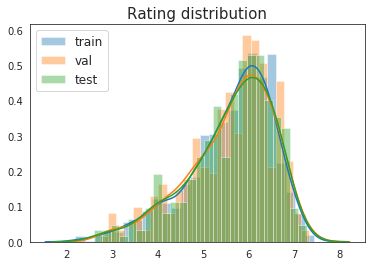

In [15]:
# check stratification for y

sns.distplot(y_train, bins=25)
sns.distplot(y_val, bins=25)
sns.distplot(y_test, bins=25)
plt.legend(labels=['train','val','test'], loc='upper left', fontsize=12)
plt.title('Rating distribution', size=15);

In [ ]:
# plot example images with min/max ratings for each data subset (train/test/val)
# Note: output not shown in GitHub because of license agreement for face images

plt.figure(figsize=(13,4))

# train data with min and max rating
plt.subplot(161)
idx = y_train.argmin()
plt.imshow(X_train[idx])  # /255.0)
plt.title('train - min\n{:.2f}'.format(y_train[idx]));

plt.subplot(162)
idx = y_train.argmax() 
plt.imshow(X_train[idx]) # /255.0)
plt.title('train - max\n{:.2f}'.format(y_train[idx]));


# validation data with min and max rating
plt.subplot(163)
idx = y_val.argmin()
plt.imshow(X_val[idx])  # /255.0)
plt.title('val - min\n{:.2f}'.format(y_val[idx]));

plt.subplot(164)
idx = y_val.argmax() 
plt.imshow(X_val[idx]) # /255.0)
plt.title('val - max\n{:.2f}'.format(y_val[idx]));


# test data with min and max rating
plt.subplot(165)
idx = y_test.argmin()
plt.imshow(X_test[idx])  # /255.0)
plt.title('test - min\n{:.2f}'.format(y_test[idx]));

plt.subplot(166)
idx = y_test.argmax()
plt.imshow(X_test[idx])  # /255.0)
plt.title('test - max\n{:.2f}'.format(y_test[idx]));
plt.tight_layout();

---
# 4) Preprocess Images

## a) Mean-centering

In [17]:
# take the mean of training set for mean-centering of train/val/test set later

X_mean = np.mean(X_train, axis=0)
X_mean.shape

(224, 224, 3)

In [0]:
# write functon to center (or decenter) X using mean of training data:

def center_X(X):
    return X - X_mean

def decenter_X(X):
    return X + X_mean

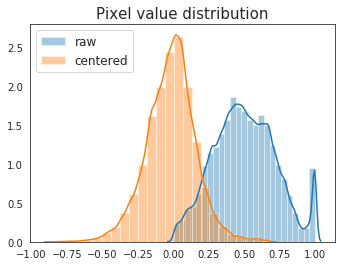

In [19]:
# plot pixel value distribution for raw and centered image arrays

fig = plt.figure(figsize=(12,4))
fig.add_subplot(121)
sns.distplot(X_train[:10,:,:,:].ravel(), bins=25); 
sns.distplot(center_X(X_train)[:10,:,:,:].ravel(), bins=25); 
plt.legend(labels=['raw','centered'], loc='upper left', fontsize=12)
plt.title('Pixel value distribution', size=15);

## b) Data Augmentation

**Some notes about data augmentation**:
- see: https://stackoverflow.com/questions/42443936/; https://github.com/keras-team/keras/issues/5862

Data augmentation takes the approach of generating more training data from existing training samples by augmenting the samples using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

Implement this in tf.keras using the ImageDataGenerator class. Pass different transformations to the dataset and it will take care of applying it during the training process.

CAVE: Generally, only apply data augmentation to the TRAINING examples (not on VALIDATION/TEST examples)!


In [0]:
# Option 1: for non-extracted face images

from tensorflow.keras.preprocessing.image import ImageDataGenerator

if X_name == 'Xs':
    traingen = ImageDataGenerator(
                        # rescale=1./255,         # not needed here, already 0-1
                        rotation_range=15,        # degree range for random rotations
                        # brightness_range=[0.5,1.0], # randomly brighten (>1) or darken (<1) the image
                        width_shift_range=.1,     # fraction of total width (if <1)
                        height_shift_range=.1,    # fraction of total width (if <1)
                        fill_mode='constant',     # points outside the boundaries of the input are filled according to the given mode
                        cval=1,                   # value used for points outside the boundaries when fill_mode = "constant"
                        horizontal_flip=True      # makes randomly mirror-images
                        #shear_range=140,         # shear intensity (don't apply, distorts the faces!)
                        #zoom_range=0.1)          # range for random zoom (don't apply, distorts the faces!)
                        
  
# compute quantities required for featurewise normalization
# only required if featurewise_center or featurewise_std_normalization or zca_whitening are set to True.
# datagen.fit(center_X(X_train))

In [0]:
# Option 2: for extracted face images

from tensorflow.keras.preprocessing.image import ImageDataGenerator

if X_name == 'Xf':
    traingen = ImageDataGenerator(
                        rescale=1./255,             # not needed here, already 0-1 >> but use if brightness_range is applied!
                        rotation_range=10,          # degree range for random rotations
                        brightness_range=[0.8,1.2], # randomly brighten (>1) or darken (<1) the image
                        # width_shift_range=.1,     # fraction of total width (if <1)
                        # height_shift_range=.1,    # fraction of total width (if <1)
                        fill_mode='nearest',        # points outside the boundaries of the input are filled according to the given mode
                        #cval=1,                    # value used for points outside the boundaries when fill_mode = "constant"
                        horizontal_flip=True,       # makes randomly mirror-images
                        #shear_range=140,           # shear intensity (don't apply, distorts the faces!)
                        zoom_range=0.1,             # range for random zoom (don't apply, distorts the faces!)
                        )

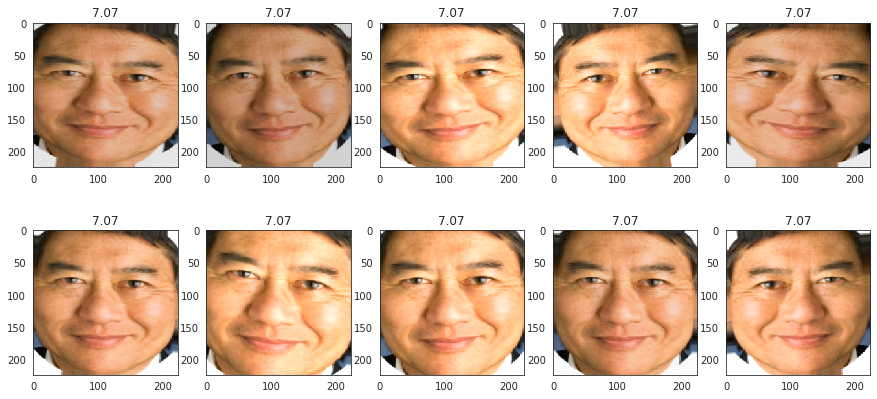

In [36]:
# check what the generator does to one example image (use publication-friendly images for demonstration)

n_gen = 10
img_idx = 12

X_public = np.load(data_dir_bucket + 'Xf_public.npy')

fig = plt.figure(figsize=(15,7))
for i, (X_gen, y_gen) in enumerate(traingen.flow(X_public[img_idx:img_idx+1,], 
                                   y_train[img_idx:img_idx+1,], # ,seed=0
                                   batch_size=1),start=1):
    plt.subplot(2,5,i)
    plt.imshow(X_gen[0])
    plt.title(y_gen[0])
    i += 1
    if i > n_gen:
        break

---
# 5) Build Model
Note: For the following models, the abbreviation **aug** always refers to **image data augmentation** and the abbreviation **reg** to **regularization**.

## a) CNN from scratch (m01)


### m01a: simple model (no aug/reg)

In [0]:
# see: https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

def create_model_m01a():
    name = 'm01a'

    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
    from tensorflow.keras.models import Sequential

    input_shape = X_train[0].shape
    model = Sequential(name=name)

    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                  input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, name='regressor'))

    return model

In [0]:
# include preprocess_input function into data generator for train and val set

def preprocess_input_center(x):
    return center_X(x)

traingen = ImageDataGenerator(preprocessing_function = preprocess_input_center)
valgen = ImageDataGenerator(preprocessing_function = preprocess_input_center)

### m01b: simple model with different architecture (no aug/reg)

In [0]:
# see: paper from Messer & Fausser

def create_model_m01b():
    name = 'm01b'

    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
    from tensorflow.keras.models import Sequential

    input_shape = X_train[0].shape
    model = Sequential(name=name)

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', 
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, name='regressor'))

    return model

In [0]:
# include preprocess_input function into data generator for train and val set

def preprocess_input_center(x):
    return center_X(x)
  
traingen = ImageDataGenerator(preprocessing_function = preprocess_input_center)
valgen = ImageDataGenerator(preprocessing_function = preprocess_input_center)

### m01c: m01a + aug (no reg)

In [0]:
# include preprocess_input function into data generator for train and val set

def preprocess_input_center(x):
    return center_X(x)
  
traingen = ImageDataGenerator(
                        rescale=1./255,           # not needed here, already 0-1 >> but use if brightness_range is applied!
                        rotation_range=10,        # degree range for random rotations
                        brightness_range=[0.8,1.2], # randomly brighten (>1) or darken (<1) the image
                        fill_mode='nearest',      # points outside the boundaries of the input are filled according to the given mode
                        horizontal_flip=True,     # makes randomly mirror-images
                        zoom_range=0.1,           # range for random zoom
                        preprocessing_function = preprocess_input_center)

valgen = ImageDataGenerator(preprocessing_function = preprocess_input_center)

### m01d: m01a + different aug (no reg)

In [0]:
# include preprocess_input function into data generator for train and val set

def preprocess_input_center(x):
    x_pp = center_X(x)
    return x_pp
  
traingen = ImageDataGenerator(
                        rescale=1./255,             # not needed here, already 0-1 >> but use if brightness_range is applied!
                        rotation_range=10,          # degree range for random rotations
                        brightness_range=[0.9,1.1], # randomly brighten (>1) or darken (<1) the image
                        fill_mode='nearest',        # points outside the boundaries of the input are filled according to the given mode
                        horizontal_flip=True,       # makes randomly mirror-images
                        #zoom_range=0.1,            # range for random zoom
                        preprocessing_function = preprocess_input_center)

valgen = ImageDataGenerator(preprocessing_function = preprocess_input_center)

### m01e: m01a + dropout (no aug)


In [0]:
def create_model_m01e():
    name = 'm01e'

    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
    from tensorflow.keras.models import Sequential

    input_shape = X_train[0].shape
    model = Sequential(name=name)

    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))                     # added Dropout

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))                     # added Dropout

    model.add(Dense(1, name='regressor'))

    return model

In [0]:
# include preprocess_input function into data generator for train and val set

def preprocess_input_center(x):
    return center_X(x)
  
traingen = ImageDataGenerator(preprocessing_function = preprocess_input_center)
valgen = ImageDataGenerator(preprocessing_function = preprocess_input_center)

## b) Resnet50 as base model (m02)

### m02a: Resnet50 + Dense (no aug/reg)

In [0]:
# see: https://github.com/shudima/notebooks/blob/master/Beauty%20Classifier.ipynb

def create_model_m02a():
    name = 'm02a'

    # load dependencies for keras model
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.applications import ResNet50
    from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D

    input_shape = X_train[0].shape
    resnet = ResNet50(include_top=False, 
                      pooling='avg', 
                      weights='imagenet',
                      input_shape=input_shape) # https://keras.io/applications/#resnet: default input size for this model is 224x224
  
    # build model
    model = Sequential(name=name)
    model.add(resnet)
    model.add(Dense(1, name='regressor'))

    return model

In [0]:
# include preprocess_input function into data generator for train and val set
# Caution: using 'x_new = preprocess_input(x)' does also change x!

from tensorflow.keras.applications.resnet50 import preprocess_input

def preprocess_input_resnet50(x):
    x_pp = preprocess_input(x*255)
    return x_pp

traingen = ImageDataGenerator(preprocessing_function = preprocess_input_resnet50)
valgen = ImageDataGenerator(preprocessing_function = preprocess_input_resnet50)

### m02b: m02a + aug (no reg)

In [0]:
# include preprocess_input function into data generator for train and val set
# Caution: using 'x_new = preprocess_input(x)' does also change x!

from tensorflow.keras.applications.resnet50 import preprocess_input

def preprocess_input_resnet50(x):
    x_pp = preprocess_input(x*255)
    return x_pp

traingen = ImageDataGenerator(
                        #rescale=1./255,          # not needed here, already 0-1 >> but use if brightness_range is applied!!!
                        rotation_range=10,        # degree range for random rotations
                        #brightness_range=[0.8,1.2], # randomly brighten (>1) or darken (<1) the image
                        fill_mode='nearest',      # points outside the boundaries of the input are filled according to the given mode
                        horizontal_flip=True,     # makes randomly mirror-images
                        zoom_range=0.1,           # range for random zoom
                        preprocessing_function = preprocess_input_resnet50)

valgen = ImageDataGenerator(preprocessing_function = preprocess_input_resnet50)

### m02c: Resnet50 + 3 Dense (no aug/reg)

In [0]:
# see: https://github.com/shudima/notebooks/blob/master/Beauty%20Classifier.ipynb

def create_model_m02c():
    name = 'm02c'

    # load dependencies for keras model
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.applications import ResNet50
    from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D

    input_shape = X_train[0].shape
    resnet = ResNet50(include_top=False, 
                      pooling='avg', 
                      weights='imagenet',
                      input_shape=input_shape) # https://keras.io/applications/#resnet: default input size for this model is 224x224
  
    # build model
    model = Sequential(name=name)
    model.add(resnet)
    model.add(Flatten())
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(1, name='regressor'))

    return model

In [0]:
# include preprocess_input function into data generator for train and val set
# Caution: using 'x_new = preprocess_input(x)' does also change x!

from tensorflow.keras.applications.resnet50 import preprocess_input

def preprocess_input_resnet50(x):
    x_pp = preprocess_input(x*255)
    return x_pp

traingen = ImageDataGenerator(preprocessing_function = preprocess_input_resnet50)
valgen = ImageDataGenerator(preprocessing_function = preprocess_input_resnet50)

### m02d: m02c + aug (no reg)

In [0]:
# include preprocess_input function into data generator for train and val set
# Caution: using 'x_new = preprocess_input(x)' does also change x!

from tensorflow.keras.applications.resnet50 import preprocess_input

def preprocess_input_resnet50(x):
    x_pp = preprocess_input(x*255)
    return x_pp

traingen = ImageDataGenerator(
                        #rescale=1./255,          # not needed here, already 0-1 >> but use if brightness_range is applied!!!
                        rotation_range=10,        # degree range for random rotations
                        #brightness_range=[0.8,1.2], # randomly brighten (>1) or darken (<1) the image
                        fill_mode='nearest',      # points outside the boundaries of the input are filled according to the given mode
                        horizontal_flip=True,     # makes randomly mirror-images
                        zoom_range=0.1,           # range for random zoom
                        preprocessing_function = preprocess_input_resnet50)

valgen = ImageDataGenerator(preprocessing_function = preprocess_input_resnet50)

### m02e: m02c + aug + reg (Dropout)

In [0]:
# see: https://github.com/shudima/notebooks/blob/master/Beauty%20Classifier.ipynb

def create_model_m02e():
    name = 'm02e'

    # load dependencies for keras model
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.applications import ResNet50
    from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout

    input_shape = X_train[0].shape
    resnet = ResNet50(include_top=False, 
                      pooling='avg', 
                      weights='imagenet',
                      input_shape=input_shape) # https://keras.io/applications/#resnet: default input size for this model is 224x224
  
    # build model
    model = Sequential(name=name)
    model.add(resnet)
    model.add(Flatten())
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.3))                    # added dropout
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.3))                    # added dropout
    model.add(Dense(1, name='regressor'))

    return model

In [0]:
# include preprocess_input function into data generator for train and val set
# Caution: using 'x_new = preprocess_input(x)' does also change x!

from tensorflow.keras.applications.resnet50 import preprocess_input

def preprocess_input_resnet50(x):
    x_pp = preprocess_input(x*255)
    return x_pp

traingen = ImageDataGenerator(
                        #rescale=1./255,          # not needed here, already 0-1 >> but use if brightness_range is applied!!!
                        rotation_range=10,        # degree range for random rotations
                        #brightness_range=[0.8,1.2], # randomly brighten (>1) or darken (<1) the image
                        fill_mode='nearest',      # points outside the boundaries of the input are filled according to the given mode
                        horizontal_flip=True,     # makes randomly mirror-images
                        zoom_range=0.1,           # range for random zoom
                        preprocessing_function = preprocess_input_resnet50)

valgen = ImageDataGenerator(preprocessing_function = preprocess_input_resnet50)

### m02f: m02c + aug + reg (Dropout, L2)

In [0]:
# see: https://github.com/shudima/notebooks/blob/master/Beauty%20Classifier.ipynb

def create_model_m02f():
    name = 'm02f'

    # load dependencies for keras model
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.applications import ResNet50
    from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
    from tensorflow.keras.regularizers import l2

    input_shape = X_train[0].shape
    resnet = ResNet50(include_top=False, 
                      pooling='avg', 
                      weights='imagenet',
                      input_shape=input_shape) # https://keras.io/applications/#resnet: default input size for this model is 224x224
  
    # L2 parameter (weight decay)
    # see: https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/
    l2_value = 0.0005

    # build model
    model = Sequential(name=name)
    model.add(resnet)
    model.add(Flatten())

    model.add(Dense(2048, activation='relu', 
              kernel_regularizer=l2(l2_value)))     # added L2
    model.add(Dropout(0.3))                         # added dropout

    model.add(Dense(2048, activation='relu', 
              kernel_regularizer=l2(l2_value)))     # added L2
    model.add(Dropout(0.3))                         # added dropout

    model.add(Dense(1, name='regressor'))

    return model

In [0]:
# include preprocess_input function into data generator for train and val set
# Caution: using 'x_new = preprocess_input(x)' does also change x!

from tensorflow.keras.applications.resnet50 import preprocess_input

def preprocess_input_resnet50(x):
    x_pp = preprocess_input(x*255)
    return x_pp

traingen = ImageDataGenerator(
                        #rescale=1./255,          # not needed here, already 0-1 >> but use if brightness_range is applied!!!
                        rotation_range=10,        # degree range for random rotations
                        #brightness_range=[0.8,1.2], # randomly brighten (>1) or darken (<1) the image
                        fill_mode='nearest',      # points outside the boundaries of the input are filled according to the given mode
                        horizontal_flip=True,     # makes randomly mirror-images
                        zoom_range=0.1,           # range for random zoom
                        preprocessing_function = preprocess_input_resnet50)

valgen = ImageDataGenerator(preprocessing_function = preprocess_input_resnet50)

### m02g: m02c + aug + reg (L2)

In [0]:
# see: https://github.com/shudima/notebooks/blob/master/Beauty%20Classifier.ipynb

def create_model_m02g():
    name = 'm02g'

    # load dependencies for keras model
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.applications import ResNet50
    from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
    from tensorflow.keras.regularizers import l2

    input_shape = X_train[0].shape
    resnet = ResNet50(include_top=False, 
                      pooling='avg', 
                      weights='imagenet',
                      input_shape=input_shape) # https://keras.io/applications/#resnet: default input size for this model is 224x224
  
    # L2 parameter (weight decay)
    # see: https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/
    l2_value = 0.0005

    # build model
    model = Sequential(name=name)
    model.add(resnet)
    model.add(Flatten())

    model.add(Dense(2048, activation='relu', 
                  kernel_regularizer=l2(l2_value)))     # added L2
    model.add(Dense(2048, activation='relu', 
                  kernel_regularizer=l2(l2_value)))     # added L2
    model.add(Dense(1, name='regressor'))

    return model

In [0]:
# include preprocess_input function into data generator for train and val set
# Caution: using 'x_new = preprocess_input(x)' does also change x!

from tensorflow.keras.applications.resnet50 import preprocess_input

def preprocess_input_resnet50(x):
    x_pp = preprocess_input(x*255)
    return x_pp

traingen = ImageDataGenerator(
                        #rescale=1./255,          # not needed here, already 0-1 >> but use if brightness_range is applied!!!
                        rotation_range=10,        # degree range for random rotations
                        #brightness_range=[0.8,1.2], # randomly brighten (>1) or darken (<1) the image
                        fill_mode='nearest',      # points outside the boundaries of the input are filled according to the given mode
                        horizontal_flip=True,     # makes randomly mirror-images
                        zoom_range=0.1,           # range for random zoom
                        preprocessing_function = preprocess_input_resnet50)

valgen = ImageDataGenerator(preprocessing_function = preprocess_input_resnet50)

### m02h: m02c + aug + reg (WC)

In [0]:
def create_model_m02h():
    name = 'm02h'

    # load dependencies for keras model
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.applications import ResNet50
    from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
    from tensorflow.keras.constraints import max_norm

    input_shape = X_train[0].shape
    resnet = ResNet50(include_top=False, 
                      pooling='avg', 
                      weights='imagenet',
                      input_shape=input_shape) # https://keras.io/applications/#resnet: default input size for this model is 224x224
  
    # instantiate norm
    norm = max_norm(3.0)

    # build model
    model = Sequential(name=name)
    model.add(resnet)
    model.add(Flatten())

    model.add(Dense(2048, activation='relu',  
                kernel_constraint = norm))     # added weight constraint (WC)
    model.add(Dense(2048, activation='relu', 
                kernel_constraint = norm))     # added weight constraint (WC)
    model.add(Dense(1, name='regressor'))

    return model

In [0]:
# include preprocess_input function into data generator for train and val set
# Caution: using 'x_new = preprocess_input(x)' does also change x!

from tensorflow.keras.applications.resnet50 import preprocess_input

def preprocess_input_resnet50(x):
    x_pp = preprocess_input(x*255)
    return x_pp

traingen = ImageDataGenerator(
                        #rescale=1./255,          # not needed here, already 0-1 >> but use if brightness_range is applied!!!
                        rotation_range=10,        # degree range for random rotations
                        #brightness_range=[0.8,1.2], # randomly brighten (>1) or darken (<1) the image
                        fill_mode='nearest',      # points outside the boundaries of the input are filled according to the given mode
                        horizontal_flip=True,     # makes randomly mirror-images
                        zoom_range=0.1,           # range for random zoom
                        preprocessing_function = preprocess_input_resnet50)

valgen = ImageDataGenerator(preprocessing_function = preprocess_input_resnet50)

### m02i: m02c + aug + reg (WC, small Dropout) 

In [0]:
def create_model_m02i():
    name = 'm02i'

    # load dependencies for keras model
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.applications import ResNet50
    from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
    from tensorflow.keras.regularizers import l1

    input_shape = X_train[0].shape
    resnet = ResNet50(include_top=False, 
                      pooling='avg', 
                      weights='imagenet',
                      input_shape=input_shape) # https://keras.io/applications/#resnet: default input size for this model is 224x224
  
    # instantiate regularizer
    # see: https://machinelearningmastery.com/how-to-reduce-generalization-error-in-deep-neural-networks-with-activity-regularization-in-keras/
    l1_value = 0.001  

    # build model
    model = Sequential(name=name)
    model.add(resnet)
    model.add(Flatten())

    model.add(Dense(2048, activation='relu',  
              activity_regularizer=l1(l1_value)))   # added L1
    model.add(Dropout(0.1))                         # added dropout

    model.add(Dense(2048, activation='relu', 
              activity_regularizer=l1(l1_value)))   # added L1
    model.add(Dropout(0.1))                         # added dropout

    model.add(Dense(1, name='regressor'))

    return model

In [0]:
# include preprocess_input function into data generator for train and val set
# Caution: using 'x_new = preprocess_input(x)' does also change x!

from tensorflow.keras.applications.resnet50 import preprocess_input

def preprocess_input_resnet50(x):
    x_pp = preprocess_input(x*255)
    return x_pp

traingen = ImageDataGenerator(
                        #rescale=1./255,          # not needed here, already 0-1 >> but use if brightness_range is applied!!!
                        rotation_range=10,        # degree range for random rotations
                        #brightness_range=[0.8,1.2], # randomly brighten (>1) or darken (<1) the image
                        fill_mode='nearest',      # points outside the boundaries of the input are filled according to the given mode
                        horizontal_flip=True,     # makes randomly mirror-images
                        zoom_range=0.1,           # range for random zoom
                        preprocessing_function = preprocess_input_resnet50)

valgen = ImageDataGenerator(preprocessing_function = preprocess_input_resnet50)

### m02k: m02c - all base model layers frozen

In [0]:
# see: https://github.com/shudima/notebooks/blob/master/Beauty%20Classifier.ipynb

def create_model_m02k():
    name = 'm02k'

    # load dependencies for keras model
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.applications import ResNet50
    from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D

    input_shape = X_train[0].shape
    resnet = ResNet50(include_top=False, 
                      pooling='avg', 
                      weights='imagenet',
                      input_shape=input_shape) # https://keras.io/applications/#resnet: default input size for this model is 224x224
  
    # set trainable and frozen layers of Resnet50:
    # see: https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

    # build model
    model = Sequential(name=name)
    model.add(resnet)
    model.add(Flatten())
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(1, name='regressor'))

    # freeze resnet model
    model.layers[0].trainable = False

    return model

In [0]:
# include preprocess_input function into data generator for train and val set
# Caution: using 'x_new = preprocess_input(x)' does also change x!

from tensorflow.keras.applications.resnet50 import preprocess_input

def preprocess_input_resnet50(x):
    x_pp = preprocess_input(x*255)
    return x_pp

traingen = ImageDataGenerator(preprocessing_function = preprocess_input_resnet50)
valgen = ImageDataGenerator(preprocessing_function = preprocess_input_resnet50)

### m02m: m02c - only selected layers frozen

In [0]:
# see: https://github.com/shudima/notebooks/blob/master/Beauty%20Classifier.ipynb

def create_model_m02m(first_unfrozen_layer = 4):
    name = 'm02m'

    # load dependencies for keras model
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.applications import ResNet50
    from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D

    input_shape = X_train[0].shape
    resnet = ResNet50(include_top=False, 
                      pooling='avg', 
                      weights='imagenet',
                      input_shape=input_shape) # https://keras.io/applications/#resnet: default input size for this model is 224x224
  
    # set trainable and frozen layers of Resnet50:
    # see: https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

    resnet.trainable = True
    set_trainable = False
    for layer in resnet.layers:
        if layer.name == f'conv{first_unfrozen_layer}_block1_1_conv':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False 

    # show frozen and trainable layers in dataframe:
    pd.set_option('max_colwidth', -1)
    pd.options.display.max_rows = 500
    layers = [(layer, layer.name, layer.trainable) for layer in resnet.layers]
    #display(pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']))

    # build model
    model = Sequential(name=name)
    model.add(resnet)
    model.add(Flatten())
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(1, name='regressor'))

    return model

In [0]:
# include preprocess_input function into data generator for train and val set
# Caution: using 'x_new = preprocess_input(x)' does also change x!

from tensorflow.keras.applications.resnet50 import preprocess_input

def preprocess_input_resnet50(x):
    x_pp = preprocess_input(x*255)
    return x_pp

traingen = ImageDataGenerator(preprocessing_function = preprocess_input_resnet50)
valgen = ImageDataGenerator(preprocessing_function = preprocess_input_resnet50)

## c) VGGface2 as base model (m03)
Note: For the following models, first install the vggface package from GitHub (see below).

In [21]:
# install VGGFace(2)) models in Keras
%%capture
!pip install git+https://github.com/rcmalli/keras-vggface.git

# confirm that the library was installed correctly 
!pip show keras-vggface

Name: keras-vggface
Version: 0.6
Summary: VGGFace implementation with Keras framework
Home-page: https://github.com/rcmalli/keras-vggface
Author: Refik Can MALLI
Author-email: mallir@itu.edu.tr
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: pillow, pyyaml, h5py, keras, six, scipy, numpy
Required-by: 


In [22]:
# check version of keras_vggface

import keras_vggface
print(keras_vggface.__version__)

0.6


Using TensorFlow backend.


### m03a: VGGface2 + Dense (no aug/reg) - all layers trainable

In [0]:
# see: https://github.com/shudima/notebooks/blob/master/Beauty%20Classifier.ipynb

def create_model_m03a(model_type='resnet50'):  # 'vgg16', 'senet50'
    name = 'm03a_' + model_type

    # load dependencies for keras model
    # Caution: use keras instead of tensorflow.keras here because of vggface model
    # see: https://stackoverflow.com/questions/55324762/

    from keras.models import Sequential
    from keras_vggface.vggface import VGGFace
    from keras.layers import Dense  #, Flatten, GlobalAveragePooling2D, Input

    # create a vggface2 base model
    input_shape = X_train[0].shape
    vggface = VGGFace(model=model_type,
                      include_top=False, 
                      pooling='avg',           # pooling: None, avg or max
                      weights='vggface',
                      input_shape=input_shape) # default: (224, 224, 3)
  
    # build model
    model = Sequential(name=name)
    model.add(vggface)
    model.add(Dense(1, name='regressor'))

    return model

In [0]:
# include preprocess_input function to datagen iterator for train and val set
# see: https://towardsdatascience.com/transfer-learning-for-image-classification-using-keras-c47ccf09c8c8

from keras_vggface.utils import preprocess_input

def preprocess_input_vggface(x, model_type='vgg16'):
    if model_type=='vgg16':
        model_version=1
    elif (model_type=='resnet50') | (model_type=='senet50'):
        model_version=2
    x_pp = preprocess_input(x*255, version=model_version)
    return x_pp

traingen = ImageDataGenerator(preprocessing_function = preprocess_input_vggface)
valgen = ImageDataGenerator(preprocessing_function = preprocess_input_vggface)

### m03b: VGGface2 + 3 Dense (no aug/reg) - all layers trainable

In [0]:
def create_model_m03b(model_type='resnet50'):  # 'vgg16', 'senet50'
    name = 'm03b_' + model_type

    # load dependencies for keras model
    # Caution: use keras instead of tensorflow.keras here because of vggface model
    # see: https://stackoverflow.com/questions/55324762/

    from keras.models import Sequential
    from keras_vggface.vggface import VGGFace
    from keras.layers import Dense  #, Flatten, GlobalAveragePooling2D, Input

    # create a vggface2 base model
    input_shape = X_train[0].shape
    vggface = VGGFace(model=model_type,
                      include_top=False, 
                      pooling='avg',            # pooling: None, avg or max
                      weights='vggface',
                      input_shape=input_shape)  # default: (224, 224, 3)

    n_hidden = vggface.output_shape[1]  # use 2048 for resnet50/senet50 and 512 for vgg16

    # build model
    model = Sequential(name=name)
    model.add(vggface)
    #model.add(Flatten()) .   # include Flatten if pooling=None
    model.add(Dense(n_hidden, activation='relu'))
    model.add(Dense(n_hidden, activation='relu'))
    model.add(Dense(1, name='regressor'))

    return model

In [0]:
# include preprocess_input function to datagen iterator for train and val set
# see: https://towardsdatascience.com/transfer-learning-for-image-classification-using-keras-c47ccf09c8c8

from keras_vggface.utils import preprocess_input

def preprocess_input_vggface(x, model_type='resnet50'):
    if model_type=='vgg16':
        model_version=1
    elif (model_type=='resnet50') | (model_type=='senet50'):
        model_version=2
    x_pp = preprocess_input(x*255, version=model_version)
    return x_pp

traingen = ImageDataGenerator(preprocessing_function = preprocess_input_vggface)
valgen = ImageDataGenerator(preprocessing_function = preprocess_input_vggface)

### m03c: m03b + aug (no reg) - all layers trainable

In [0]:
# include preprocess_input function to datagen iterator for train and val set
# see: https://towardsdatascience.com/transfer-learning-for-image-classification-using-keras-c47ccf09c8c8

from keras_vggface.utils import preprocess_input

def preprocess_input_vggface(x, model_type='resnet50'):
    if model_type=='vgg16':
        model_version=1
    elif (model_type=='resnet50') | (model_type=='senet50'):
        model_version=2
    x_pp = preprocess_input(x*255, version=model_version)
    return x_pp

traingen = ImageDataGenerator(
                        #rescale=1./255,          # not needed here, already 0-1 >> but use if brightness_range is applied!!!
                        rotation_range=10,        # degree range for random rotations
                        #brightness_range=[0.8,1.2], # randomly brighten (>1) or darken (<1) the image
                        fill_mode='nearest',      # points outside the boundaries of the input are filled according to the given mode
                        horizontal_flip=True,     # makes randomly mirror-images
                        zoom_range=0.1,           # range for random zoom
                        preprocessing_function = preprocess_input_vggface)

valgen = ImageDataGenerator(preprocessing_function = preprocess_input_vggface)

### m03d: m03b (no aug/reg) - selected layers frozen

In [0]:
def create_model_m03d(model_type='resnet50',     # select from: 'vgg16', 'resnet50', 'senet50'
                      first_unfrozen_layer=3,    # select first unfrozen (trainable) layer
                      display_layers=False,      # select to print trainable/frozen layers when creating model
                      dropout=None,              # specify dropout, e.g. 0.1
                      L2=None,                   # L2 regularization
                      WC=None):                  # weight constraint
    name = 'm03d_' + model_type

    # load dependencies for keras model
    # Caution: use keras instead of tensorflow.keras here because of vggface model
    # see: https://stackoverflow.com/questions/55324762/

    from keras.models import Sequential
    from keras_vggface.vggface import VGGFace
    from keras.layers import Dense, Dropout, Flatten  # GlobalAveragePooling2D, Input

    # create a vggface2 base model
    input_shape = X_train[0].shape
    vggface = VGGFace(model=model_type,
                      include_top=False, 
                      pooling='avg',  # pooling: None (default), avg or max (when None include Flatten layer below)
                      weights='vggface',
                      input_shape=input_shape) # default: (224, 224, 3)
    n_hidden = 2048   # use 2048 for resnet50/senet50 and 512 for vgg16 (only if pooling!=None)

    # set trainable and frozen layers of base model:
    # see: https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

    vggface.trainable = True
    set_trainable = False
    for layer in vggface.layers:
        if layer.name == f'conv{first_unfrozen_layer}_1_1x1_reduce':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False 

    # show frozen and trainable layers in dataframe
    if display_layers:
        pd.set_option('max_colwidth', -1)
        pd.options.display.max_rows = 500
        layers = [(layer, layer.name, layer.trainable) for layer in vggface.layers]
        display(pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']))


    # add regularizer (https://keras.io/regularizers/)
    if L2:
        from keras.regularizers import l2
        reg=l2(L2)  # L2 parameter (weight decay)  0.0005
                    # see: https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/
    else:
        reg=None


    # add constraint (https://keras.io/constraints/)
    if WC:
        from keras.constraints import max_norm
        con=max_norm(WC)  
    else:
        con=None  


    # build model
    model = Sequential(name=name)
    model.add(vggface)
    #model.add(Flatten())
    # An alternative approach to adding a Flatten layer is to define the base model with an average pooling layer.
    # Setting ‘pooling‘ to ‘avg‘ means that the filter maps at the output end of the model are reduced to a vector using global average pooling.
    # see: https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/
    # see: https://machinelearningmastery.com/how-to-perform-face-recognition-with-vggface2-convolutional-neural-network-in-keras/

    model.add(Dense(n_hidden, activation='relu', 
                    kernel_regularizer = reg, bias_regularizer=None, activity_regularizer=None, 
                    kernel_constraint = con, bias_constraint=None))
    if dropout: 
        model.add(Dropout(dropout))  # e.g. Dropout(0.1)

    model.add(Dense(n_hidden, activation='relu', 
                    kernel_regularizer = reg, bias_regularizer=None, activity_regularizer=None, 
                    kernel_constraint = con, bias_constraint=None))
    if dropout:
        model.add(Dropout(dropout))  # e.g. Dropout(0.1)

    model.add(Dense(1, name='regressor'))

    return model

In [0]:
# write the same model with the keras API to later use methods such as GradCAM & Guided Backpropagation on the model
# see: https://github.com/keras-team/keras/issues/10716

def create_model_m03d_API(model_type='resnet50',     # select from: 'vgg16', 'resnet50', 'senet50'
                          first_unfrozen_layer=3,
                          display_layers=False,
                          dropout=None,              # specify dropout, e.g. 0.1
                          L2=None,                   # L2 regularization
                          WC=None):                  # weight constraint
    name = 'm03d_API_' + model_type

    # load dependencies for keras model
    # Caution: use keras instead of tensorflow.keras here because of vggface model
    # see: https://stackoverflow.com/questions/55324762/t

    from keras.models import Sequential, Model
    from keras_vggface.vggface import VGGFace
    from keras.layers import Dense, Dropout, Flatten  # GlobalAveragePooling2D, Input
  
    # create a vggface2 base model
    input_shape = X_train[0].shape
    base_model = VGGFace(model=model_type,
                         include_top=False, 
                         pooling='avg',  # pooling: None (default), avg or max (when None include Flatten layer below)
                         weights='vggface',
                         input_shape=input_shape) # default: (224, 224, 3)

    # add regularizer (https://keras.io/regularizers/)
    if L2:
        from keras.regularizers import l2
        reg=l2(L2)  # L2 parameter (weight decay)  0.0005
                    # see: https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/
    else:
        reg=None

    # add constraint (https://keras.io/constraints/)
    if WC:
        from keras.constraints import max_norm
        con=max_norm(WC)  
    else:
        con=None 

    # summarize input and output shape
    n_hidden = 2048   # use 2048 for resnet50/senet50 and 512 for vgg16 (only if pooling!=None)

    # x = Flatten(name='flatten')(last_layer)
    x = Dense(n_hidden, activation='relu', 
              kernel_regularizer = reg, bias_regularizer=None, activity_regularizer=None, 
              kernel_constraint = con, bias_constraint=None)(base_model.output)
    if dropout: 
        x = Dropout(dropout)(x)   # e.g. Dropout(0.1)

    x = Dense(n_hidden, activation='relu', 
              kernel_regularizer = reg, bias_regularizer=None, activity_regularizer=None, 
              kernel_constraint = con, bias_constraint=None)(x)
    if dropout: 
        x = Dropout(dropout)(x)   # e.g. Dropout(0.1)

    out = Dense(1, name='regressor')(x)
    model = Model(base_model.input, out)
    model.name = name

    # set trainable and frozen layers of base model:
    # see: https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a
    model.trainable = True
    set_trainable = False
    for layer in model.layers:
        if layer.name == f'conv{first_unfrozen_layer}_1_1x1_reduce':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False 

    # show frozen and trainable layers in dataframe
    if display_layers:
        pd.set_option('max_colwidth', -1)
        pd.options.display.max_rows = 500
        layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
        display(pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']))

    return model

In [0]:
# include preprocess_input function to datagen iterator for train and val set
# see: https://towardsdatascience.com/transfer-learning-for-image-classification-using-keras-c47ccf09c8c8

from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.utils import preprocess_input

def preprocess_input_vggface(x, model_type='resnet50'):
    if model_type=='vgg16':
        model_version=1
    elif (model_type=='resnet50') | (model_type=='senet50'):
        model_version=2
    x_pp = preprocess_input(x*255, version=model_version)
    return x_pp

traingen = ImageDataGenerator(preprocessing_function = preprocess_input_vggface)
valgen = ImageDataGenerator(preprocessing_function = preprocess_input_vggface)

### m03e: m03d (frist_unfrozen_layer=3) + aug (no reg)

In [0]:
# include preprocess_input function to datagen iterator for train and val set
# see: https://towardsdatascience.com/transfer-learning-for-image-classification-using-keras-c47ccf09c8c8

from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.utils import preprocess_input

def preprocess_input_vggface(x, model_type='resnet50'):
    if model_type=='vgg16':
        model_version=1
    elif (model_type=='resnet50') | (model_type=='senet50'):
        model_version=2
    x_pp = preprocess_input(x*255, version=model_version)
    return x_pp

traingen = ImageDataGenerator(
                        #rescale=1./255,          # not needed here, already 0-1 >> but use if brightness_range is applied!!!
                        rotation_range=5,         # degree range for random rotations
                        brightness_range=[0.9,1.1], # randomly brighten (>1) or darken (<1) the image
                        fill_mode='nearest',      # points outside the boundaries of the input are filled according to the given mode
                        horizontal_flip=True,     # makes randomly mirror-images
                        #zoom_range=0.1,          # range for random zoom
                        preprocessing_function = preprocess_input_vggface)

valgen = ImageDataGenerator(preprocessing_function = preprocess_input_vggface)

## d) other base models (m04)

### m04a: m03d (frist_unfrozen_layer=3, no aug/reg)

In [0]:
from keras import backend as K
K.clear_session()
  
from keras.applications.inception_resnet_v2 import InceptionResNetV2
input_shape = X_train[0].shape
base_model = InceptionResNetV2(
                    include_top=False, 
                    pooling='avg',  # pooling: None (default), avg or max (when None include Flatten layer below)
                    weights='imagenet',
                    input_shape=input_shape)

In [0]:
for layer in base_model.layers:
    print(layer.name)

In [0]:
# see: https://github.com/shudima/notebooks/blob/master/Beauty%20Classifier.ipynb

def create_model_m04a(first_unfrozen_layer=102, display_layers=False):  
    name = 'm04a'

    # load dependencies for keras model
    from keras.applications.inception_resnet_v2 import InceptionResNetV2
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten  # GlobalAveragePooling2D, Input
    from keras import backend as K
    K.clear_session() # to reset layer numbers

    # create the base model
    input_shape = X_train[0].shape
    base_model = InceptionResNetV2(
                    include_top=False, 
                    pooling='avg',  # pooling: None (default), avg or max (when None include Flatten layer below)
                    weights='imagenet',
                    input_shape=input_shape) # default: (224, 224, 3)

    # summarize input and output shape
    n_hidden = base_model.output_shape[1]  

    # set trainable and frozen layers of base model:
    # see: https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

    base_model.trainable = True
    set_trainable = False
    for layer in base_model.layers:
        if layer.name == f'conv2d_{first_unfrozen_layer}':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False 

    # show frozen and trainable layers in dataframe
    if display_layers:
        pd.set_option('max_colwidth', -1)
        pd.options.display.max_rows = 1000
        layers = [(layer, layer.name, layer.trainable) for layer in base_model.layers]
        display(pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']))


    # build model
    model = Sequential(name=name)
    model.add(base_model)
    #model.add(Flatten())

    model.add(Dense(n_hidden, activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(n_hidden, activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(1, name='regressor'))

    return model

In [0]:
# include preprocess_input function to datagen iterator for train and val set

from keras.applications.inception_resnet_v2 import preprocess_input

def preprocess_input_InceptionResNetV2(x):
    x_pp = preprocess_input(x*255)
    return x_pp

traingen = ImageDataGenerator(preprocessing_function = preprocess_input_InceptionResNetV2)
valgen = ImageDataGenerator(preprocessing_function = preprocess_input_InceptionResNetV2)

---
# 6) Train Model

## a) Run 1: compile & train

In [27]:
# Step 1: create a basic model instance and show model summary (select from all models above)
#==================================================================

model = create_model_m03d(model_type='resnet50', 
                          first_unfrozen_layer=3, 
                          display_layers=True,
                          dropout=None, #0.1,
                          L2=None,  #0.01, 
                          WC=None)  #1.0)
model.summary()

94699520/94694792 [==============================] - 1s 0us/step


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f48953b79b0>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7f48953b7be0>,conv1/7x7_s2,False
2,<keras.layers.normalization.BatchNormalization object at 0x7f48953b7e48>,conv1/7x7_s2/bn,False
3,<keras.layers.core.Activation object at 0x7f48953b7f98>,activation_1,False
4,<keras.layers.pooling.MaxPooling2D object at 0x7f489a93ae48>,max_pooling2d_1,False
5,<keras.layers.convolutional.Conv2D object at 0x7f4894127c88>,conv2_1_1x1_reduce,False
6,<keras.layers.normalization.BatchNormalization object at 0x7f48940a3be0>,conv2_1_1x1_reduce/bn,False
7,<keras.layers.core.Activation object at 0x7f48940a3fd0>,activation_2,False
8,<keras.layers.convolutional.Conv2D object at 0x7f48940ac9e8>,conv2_1_3x3,False
9,<keras.layers.normalization.BatchNormalization object at 0x7f489532d668>,conv2_1_3x3/bn,False


Model: "m03d_resnet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_resnet50 (Model)     (None, 2048)              23561152  
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
regressor (Dense)            (None, 1)                 2049      
Total params: 31,955,905
Trainable params: 31,677,441
Non-trainable params: 278,464
_________________________________________________________________


In [28]:
# Step 2: create empty history dict and set options for training
#==================================================================

histories = {}
run1_epochs = 30    
total_epochs = run1_epochs
batch_size = 32
steps_per_epoch = np.ceil(n_train/batch_size).astype('int')
validation_steps = np.ceil(n_val/batch_size).astype('int')

print('epochs: {}, batch_size: {}, steps_per_epoch: {}, validation_steps: {}'.format(\
       run1_epochs, batch_size, steps_per_epoch, validation_steps))

epochs: 30, batch_size: 32, steps_per_epoch: 49, validation_steps: 11


In [0]:
# Step 3 | option 1: compile model for run 1 without LR schedule
#==================================================================

if tf_version==1:
    from keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Nadam
elif tf_version==2:
    from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Nadam

# select one optimizer
opt1 = Adam(lr = 0.0001)    # Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False, decay=1e-6)
opt2 = RMSprop(lr = 0.0001) # it's recommended to leave all parameters except for lr at their default values
opt3 = SGD(lr = 0.001, momentum=0.9, nesterov=True)
opt4 = Adagrad()   # it's recommended to leave all parameters (also lr) at their default values
opt5 = Adadelta()  # it's recommended to leave all parameters (also lr) at their default values
opt6 = Nadam()     # it's recommended to leave all parameters (also lr) at their default values

# compile the model
model.compile(loss='mse',                 # 'mean_squared_error'
              metrics= ['mse', 'mae'],    # 'mean_absolute_error'
              optimizer = opt1)           # or: optimizer='adam', optimizer=tf.keras.optimizers.Adam(lr=lr))

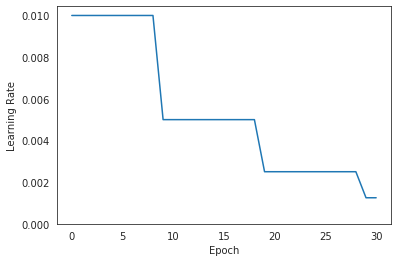

In [0]:
# Step 3 | option 2: compile model with LR schedule (with Adam)
#==================================================================
# many models train better if you gradually reduce the learning rate during training. 
# Use optimizers.schedules to reduce the learning rate over time.
# see: https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/

from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam
import math

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

# learning schedule callback
lrs = LearningRateScheduler(step_decay)

# compile model with lr=0 (to indicate that it is not used if we have a lr schedule)
model.compile(loss='mse',                 # 'mean_squared_error'
              metrics= ['mse', 'mae'],    # 'mean_absolute_error'
              optimizer=Adam(lr=0))       # or: optimizer='adam', optimizer=tf.keras.optimizers.Adam(lr=lr))

# plot the lr schedule
epochs = np.arange(31)
lr_list = [step_decay(epoch) for epoch in epochs]
plt.plot(epochs, lr_list)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Learning Rate');

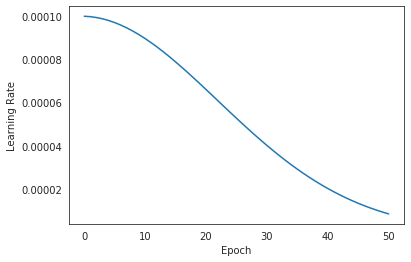

In [0]:
# Step 3 | option 3: compile model with LR schedule (with SGD)
#===============================================================

from keras.optimizers import SGD

learning_rate = 0.001
decay_rate = learning_rate / total_epochs * (0.1/learning_rate)
momentum = 0.8
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

# compile model
model.compile(loss='mse',                 # 'mean_squared_error'
              metrics= ['mse', 'mae'],    # 'mean_absolute_error'
              optimizer=sgd)  

# plot the lr schedule
def sgd_decay(epoch, lr):
    lr_new = lr * 1/(1 + decay_rate * epoch)    
    return lr_new
epochs = np.arange(total_epochs+1)
lr_list = []
lr = learning_rate
for epoch in epochs:
    lr = sgd_decay(epoch, lr)
    lr_list.append(lr)
plt.plot(epochs, lr_list)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate');          

In [0]:
# OPTIONAL: set options for early stopping
#============================================
# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min',  # minimize validation loss
                   min_delta=0.01, 
                   verbose=1, patience=10,          # wait until no improvement for 10 epochs
                   restore_best_weights=True)

In [0]:
# OPTIONAL: use checkpoint to restore best weights
#============================================

from keras.callbacks import ModelCheckpoint

cp = ModelCheckpoint(filepath= models_dir_bucket + "best_weights.hdf5",
                     monitor = 'val_loss',
                     verbose=1,
                     save_best_only=True)

In [30]:
# Step 4 | option 1: fit model (use iterator for augmentation/preprocessing)
#===========================================================================

histories['run1'] = model.fit(traingen.flow(X_train, y_train, 
                                            batch_size = batch_size), 
                              steps_per_epoch = steps_per_epoch,
                              epochs = total_epochs,
                              # callbacks = [lrs],  # use for lr schedule
                              # callbacks = [cp],   # use to save best weights
                              # callbacks = [es],   # use for early stopping
                              validation_data = valgen.flow(X_val, y_val,
                                                            batch_size = batch_size),
                              validation_steps = validation_steps )

Epoch 1/30
49/49 [==============================] - 25s 510ms/step - loss: 2.5114 - mean_squared_error: 2.5114 - mean_absolute_error: 1.0764 - val_loss: 0.5814 - val_mean_squared_error: 0.5814 - val_mean_absolute_error: 0.6121
Epoch 2/30
49/49 [==============================] - 8s 171ms/step - loss: 0.3041 - mean_squared_error: 0.3041 - mean_absolute_error: 0.4373 - val_loss: 0.8203 - val_mean_squared_error: 0.8203 - val_mean_absolute_error: 0.7597
Epoch 3/30
49/49 [==============================] - 8s 170ms/step - loss: 0.1607 - mean_squared_error: 0.1607 - mean_absolute_error: 0.3163 - val_loss: 0.4125 - val_mean_squared_error: 0.4125 - val_mean_absolute_error: 0.5186
Epoch 4/30
49/49 [==============================] - 8s 170ms/step - loss: 0.1489 - mean_squared_error: 0.1489 - mean_absolute_error: 0.3072 - val_loss: 0.4034 - val_mean_squared_error: 0.4034 - val_mean_absolute_error: 0.5038
Epoch 5/30
49/49 [==============================] - 8s 170ms/step - loss: 0.1310 - mean_squared

In [0]:
# Step 4 | option 2: fit model without iterator or input preprocessing
#========================================================================
'''
histories['run1'] = model.fit(X_train, y_train, 
                              batch_size = batch_size, 
                              #steps_per_epoch = steps_per_epoch,
                              epochs = total_epochs,
                              validation_data = (X_val, y_val),
                              #validation_steps = validation_steps
                              )
''';

In [0]:
# Step 4 | option 3: fit model with prepared augmented dataset
#================================================================
'''
history = model.fit(x = center_X_aug(X_train_aug), y = y_train_aug, 
                    batch_size = batch_size, 
                    epochs = epochs,
                    # callbacks = [es]  # include line for early stopping
                    validation_data = (center_X_aug(X_val), y_val),
                    validation_steps = validation_steps )
''';

## b) Run 2: compile & train

In [0]:
# Optional: unfreeze all layers

for layer in model.layers:
    layer.trainable = True

for layer in model.layers[0].layers:
    layer.trainable = True

In [31]:
# Continue to train the model (e.g. with smaller learning rate)

run2_epochs = 15
total_epochs = run1_epochs + run2_epochs

# Run2 starts from this layer onwards
run1_last_epoch = histories['run1'].epoch[-1]
run2_initial_epoch = run1_last_epoch + 1

run1_last_epoch, run2_initial_epoch, total_epochs

(29, 30, 45)

In [0]:
# compile model for run 2

from keras.optimizers import Adam
lr = 0.00005
model.compile(loss='mse',                 # 'mean_squared_error'
              metrics= ['mse', 'mae'],    # 'mean_absolute_error'
              optimizer=Adam(lr=lr))      

In [33]:
model.summary()

Model: "m03d_resnet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_resnet50 (Model)     (None, 2048)              23561152  
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
regressor (Dense)            (None, 1)                 2049      
Total params: 31,955,905
Trainable params: 31,677,441
Non-trainable params: 278,464
_________________________________________________________________


In [34]:
histories['run2'] = model.fit(traingen.flow(X_train, y_train, 
                                            batch_size = batch_size), 
                              steps_per_epoch = steps_per_epoch,
                              epochs = total_epochs,
                              #callbacks = [cp],
                              initial_epoch =  run2_initial_epoch,
                              validation_data = valgen.flow(X_val, y_val,
                                                            batch_size = batch_size),
                              validation_steps = validation_steps )

Epoch 31/45
49/49 [==============================] - 19s 378ms/step - loss: 0.1370 - mean_squared_error: 0.1370 - mean_absolute_error: 0.2742 - val_loss: 0.3563 - val_mean_squared_error: 0.3563 - val_mean_absolute_error: 0.4860
Epoch 32/45
49/49 [==============================] - 8s 170ms/step - loss: 0.0600 - mean_squared_error: 0.0600 - mean_absolute_error: 0.1903 - val_loss: 0.4386 - val_mean_squared_error: 0.4386 - val_mean_absolute_error: 0.5220
Epoch 33/45
49/49 [==============================] - 8s 170ms/step - loss: 0.0513 - mean_squared_error: 0.0513 - mean_absolute_error: 0.1800 - val_loss: 0.5088 - val_mean_squared_error: 0.5088 - val_mean_absolute_error: 0.5889
Epoch 34/45
49/49 [==============================] - 8s 170ms/step - loss: 0.0533 - mean_squared_error: 0.0533 - mean_absolute_error: 0.1830 - val_loss: 0.3489 - val_mean_squared_error: 0.3489 - val_mean_absolute_error: 0.4790
Epoch 35/45
49/49 [==============================] - 8s 170ms/step - loss: 0.0544 - mean_sq

## c) Run 3: compile & train

In [35]:
# Continue train the model (e.g. fine-tuning)

run3_epochs = 10
total_epochs = run1_epochs + run2_epochs + run3_epochs

# Run3 starts from this layer onwards
run2_last_epoch = histories['run2'].epoch[-1]
run3_initial_epoch = run2_last_epoch + 1

run2_last_epoch, run3_initial_epoch, total_epochs

(44, 45, 55)

In [0]:
# unfreeze all layers
for layer in model.layers:
    layer.trainable = True

# compile model
from keras.optimizers import Adam
lr = 0.00001
model.compile(loss='mse',                  # 'mean_squared_error'
              metrics= ['mse', 'mae'],     # 'mean_absolute_error'
              optimizer=Adam(lr=lr))       # optimizer='adam'

In [37]:
histories['run3'] = model.fit(traingen.flow(X_train, y_train, 
                                            batch_size = batch_size), 
                              steps_per_epoch = steps_per_epoch,
                              epochs = total_epochs,
                              initial_epoch =  run3_initial_epoch,
                              validation_data = valgen.flow(X_val, y_val,
                                                            batch_size = batch_size),
                              validation_steps = validation_steps )

Epoch 46/55
49/49 [==============================] - 20s 403ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - mean_absolute_error: 0.0951 - val_loss: 0.3000 - val_mean_squared_error: 0.3000 - val_mean_absolute_error: 0.4449
Epoch 47/55
49/49 [==============================] - 8s 172ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0755 - val_loss: 0.3449 - val_mean_squared_error: 0.3449 - val_mean_absolute_error: 0.4764
Epoch 48/55
49/49 [==============================] - 8s 171ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0811 - val_loss: 0.3006 - val_mean_squared_error: 0.3006 - val_mean_absolute_error: 0.4460
Epoch 49/55
49/49 [==============================] - 8s 171ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0586 - val_loss: 0.3054 - val_mean_squared_error: 0.3054 - val_mean_absolute_error: 0.4505
Epoch 50/55
49/49 [==============================] - 8s 170ms/step - loss: 0.0049 - mean_sq

---
# 7) Save Model

In [0]:
# write function to save the model to Google Storage bucket

def save_model(total_epochs=0):
    model_file = '_'.join([model.name, f'{total_epochs:d}ep', y_name, X_name])
    model.save(models_dir_bucket + 'final_models/' + model_file + '.h5')  #, save_format='h5')
    print('model saved to: ' + models_dir_bucket + 'final_models/' + model_file)

    import pickle
    history_file = model_file + '_histories'
    with open(models_dir_bucket + 'final_models/' + history_file, 'wb') as file_pi:
        pickle.dump(histories, file_pi)
    print('histories saved to: ' + models_dir_bucket + 'final_models/' + history_file)

In [0]:
# save model and histories to bucket

save_model(total_epochs=total_epochs)

model saved to: /content/my-bucket/models/final_models/m03d_API_resnet50_30ep_yE_Xf
histories saved to: /content/my-bucket/models/final_models/m03d_API_resnet50_30ep_yE_Xf_histories


In [0]:
# Load a saved model
# see: https://www.tensorflow.org/guide/keras/save_and_serialize

# model = keras.models.load_model('/content/my-bucket/models/final_models/m03d_API_resnet50_30ep_yF_Xf.h5')  # with h5 file extension!
# model.summary()

In [0]:
# Load saved histories
# with open('/content/my-bucket/models/m02a_90ep_yT_Xf_histories', 'rb') as f:  # create file object with permissions
#     histories = pickle.load(f)  # load using pickle de-serializer

# 8) Evaluate Model

## a) Plot train history

In [0]:
# Visualize the model's training progress using the stats stored in the history object
# see: # https://www.tensorflow.org/tutorials/keras/regression

def plot_history(history, ymax=20, use_mse=False):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    if use_mse:
        if tf_version==1:
            plt.plot(hist.epoch, hist.mean_squared_error)
            plt.plot(hist.epoch, hist.val_mean_squared_error)
        elif tf_version==2:
            plt.plot(hist.epoch, hist.mse)
            plt.plot(hist.epoch, hist.val_mse)     
    plt.plot(hist.epoch, hist.loss)  # hist.mse
    plt.plot(hist.epoch, hist.val_loss)  # hist.val_mse
    plt.ylim([0, ymax])
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epochs')
    plt.legend(labels=['train','val']);
    plt.show()

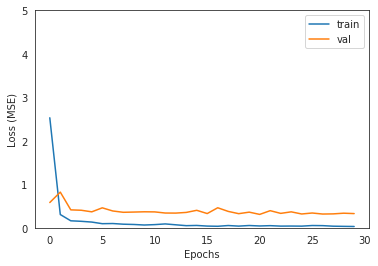

In [39]:
# plot train history of a single run (run1, run2, or run3)

plot_history(histories['run1'], ymax=5)

In [0]:
# write function to plot train histories of all runs

def plot_joint_histories(histories, ymax=20):
  
    # create dataframe with joint histories
    hist_dict = {}
    for i, run in enumerate(histories):
        history = histories[run]
        hist_dict[run] = pd.DataFrame(history.history)
        hist_dict[run]['epoch'] = history.epoch
        hist_dict[run]['run'] = run

    hist_df = pd.concat([hist for run, hist in hist_dict.items()], axis=0, ignore_index=True)

    # plot joint histories
    plt.plot(hist_df.epoch, hist_df.loss, label='train')  # hist.mse
    plt.plot(hist_df.epoch, hist_df.val_loss, label='val')  # hist.val_mse
    plt.ylim([0, ymax])
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epochs')

    # include dashed line where runs start
    runs_start_at = []
    for run in range(1,len(histories)):
        runs_start_at.append(hist_df[hist_df.run==f'run{run+1}'].first_valid_index())
    plt.vlines(runs_start_at, ymin=0, ymax=ymax,
               linestyles='dashed', color='lightgray', label='new run')
    plt.legend(loc='upper left');
    plt.show()

    return hist_df

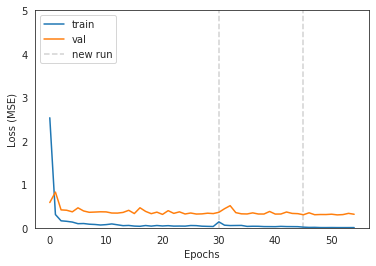

In [45]:
# plot joint train histories

histories_df = plot_joint_histories(histories, ymax=5)

## b) Plot model evaluation metrics

In [0]:
# write function to make dataframe with model statistics (RMSE, MAE, PC)

def evaluate_model(model, preprocessing_function=None, lims=(1,9)):
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    from scipy.stats import pearsonr

    if preprocessing_function != None:
        X_train_pp = preprocessing_function(X_train)
        X_val_pp = preprocessing_function(X_val)
        X_test_pp = preprocessing_function(X_test)

        y_pred_train = model.predict(X_train_pp).ravel()
        y_pred_val   = model.predict(X_val_pp).ravel()
        y_pred_test  = model.predict(X_test_pp).ravel()

    else:
        y_pred_train = model.predict(X_train).ravel()
        y_pred_val   = model.predict(X_val).ravel()
        y_pred_test  = model.predict(X_test).ravel()

    # calculate pearson correlations
    pc_train = 100*pearsonr(y_pred_train, y_train)[0]
    pc_val = 100*pearsonr(y_pred_val, y_val)[0]
    pc_test = 100*pearsonr(y_pred_test, y_test)[0]

    # calculate rmse and mae
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_val = mean_absolute_error(y_val, y_pred_val)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    df_model_eval = pd.DataFrame([[n_train, rmse_train, mae_train, pc_train],
                                  [n_val, rmse_val, mae_val, pc_val],
                                  [n_test, rmse_test, mae_test, pc_test]],
                                 index=['train', 'val', 'test'],
                                 columns=['n_samples', 'RMSE', 'MAE', 'PC'])
  
    # display evaluation metrics in dataframe
    with pd.option_context('display.float_format', '{:,.3f}'.format):
        display(df_model_eval)

    # display scatterplot and histograms
    fig = plt.figure(figsize=(15,11))

    # (1) plot correlations
    fig.add_subplot(221)
    sns.scatterplot(y_train, y_pred_train, color='blue')
    sns.scatterplot(y_val, y_pred_val, color='orange')
    sns.scatterplot(y_test, y_pred_test, color='red')
    plt.xlabel('true rating', size=12)
    plt.ylabel('predicted rating', size=12);
    plt.legend(['train','val', 'test'])
    plt.ylim(lims)
    plt.xlim(lims)
    plt.plot(lims, lims, ls="--", c='gray') 

    # (2) plot error distribution vs. rating
    fig.add_subplot(222)
    sns.scatterplot(y_train, y_pred_train - y_train, color='blue')
    sns.scatterplot(y_val, y_pred_val - y_val, color='orange')
    sns.scatterplot(y_test, y_pred_test - y_test, color='red')
    plt.legend(['train','val', 'test'])
    plt.xlabel("rating")
    plt.xlabel("prediction error")
    plt.plot(plt.gca().get_xlim(), (0,0), ls="--", c='gray') 

    # (3) plot true/predicted rating distribution
    fig.add_subplot(223)
    sns.distplot(y_pred_train, color='blue', bins = 25)
    sns.distplot(y_pred_val, color='orange', bins = 25)
    sns.distplot(y_pred_test, color='red', bins = 25)
    plt.legend(['train','val', 'test'])
    plt.xlabel("rating")

    # (4) plot error distribution
    fig.add_subplot(224)
    sns.distplot(y_pred_train - y_train, color='blue', bins = 25)
    sns.distplot(y_pred_val - y_val, color='orange', bins = 25)
    sns.distplot(y_pred_test - y_test, color='red', bins = 25)
    plt.legend(['train','val', 'test'])
    plt.xlabel("prediction error")
    plt.show();

    return df_model_eval

,n_samples,RMSE,MAE,PC
train,1554,0.115,0.097,99.782
val,334,0.558,0.455,80.965
test,334,0.591,0.471,78.749


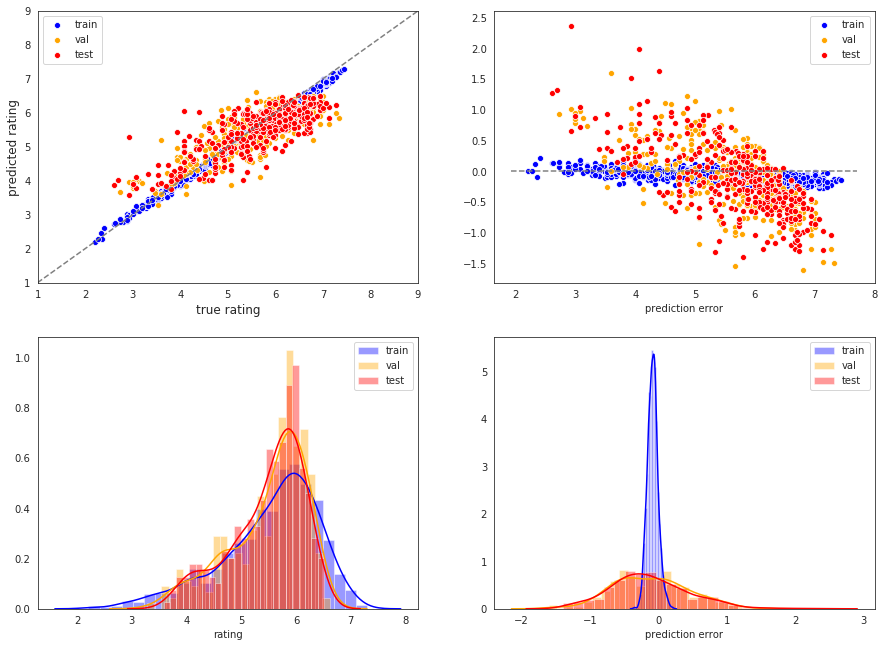

In [47]:
# show model performance (evaluation metrics and plots)

df_model_eval = evaluate_model(model,
                               preprocessing_function = preprocess_input_vggface)

In [48]:
loss, mse, mae = model.evaluate(preprocess_input(X_train*255), y_train)
loss, mse, mae

1554/1554 [==============================] - 4s 3ms/step


(0.013561267157635403, 0.013561267157635403, 0.09872732380527327)

## c) Plot faces with min/max predicted ratings

In [0]:
# write function to show min/max predictions

def plot_min_max_predictions(model, preprocessing_function, n=5):

    X_test_pp = preprocessing_function(X_test)
    y_pred_test = model.predict(X_test_pp).ravel()

    y_pred_min = y_pred_test.argsort()[:n]
    y_pred_max = y_pred_test.argsort()[-n:]

    fig, ax = plt.subplots(2,n,figsize=(3*n,7))

    for p, i in enumerate(y_pred_min,start=1):
        plt.subplot(2,n,p)
        plt.imshow(X_test[i])  #/255.0)
        plt.title('true: {:.2f}\npredicted: {:.2f}'.format(y_test[i], y_pred_test[i]))
        plt.axis('off');

    for p, i in enumerate(y_pred_max,start=n+1):
        plt.subplot(2,n,p)
        plt.imshow(X_test[i])  #/255.0)
        plt.title('true: {:.2f}\npredicted: {:.2f}'.format(y_test[i], y_pred_test[i]))
        plt.axis('off');

    plt.show();

In [ ]:
# plot faces with min/max predicted ratings
# Note: output not shown in GitHub because of license agreement for face images

plot_min_max_predictions(model, 
                         preprocessing_function = preprocess_input_vggface,
                         n=4)

---
# 9) Appendix

## a) Stratified train/val/test split

In [0]:
# load all attribute ratings (mean ratings) from bucket
'''
df_ratings = pd.read_csv(data_dir_bucket + 'df_ratings.csv')
display(df_ratings.head(3))
display(df_ratings.tail(3))
'''

In [0]:
# save single attribute ratings to bucket (to load later)
'''
yA = df_ratings.attractive.values
np.save(data_dir_bucket + 'yA.npy', yA)

yF = df_ratings.friendly.values
np.save(data_dir_bucket + 'yF.npy', yF)

yE = df_ratings.emotional.values
np.save(data_dir_bucket + 'yE.npy', yE)

yS = df_ratings.sociable.values
np.save(data_dir_bucket + 'yS.npy', yS)

yI = df_ratings.intelligent.values
np.save(data_dir_bucket + 'yI.npy', yI)
'''

In [0]:
# or: load and save PCA ratings
'''
df_ratings = pd.read_csv(data_dir_bucket + 'df_PCA_transformed.csv')
display(df_ratings.head(3))
display(df_ratings.tail(3))

# save single PC ratings to bucket (to load later)

yPC1 = df_ratings.PC1.values
np.save(data_dir_bucket + 'yPC1.npy', yPC1)

yPC2 = df_ratings.PC2.values
np.save(data_dir_bucket + 'yPC2.npy', yPC2)
'''

In [0]:
# choose type of X and y values for modeling and load data
'''
y_name = 'yPC2'  # yT, yA, yI, yE, yF, yS, yPC1, yPC2
X_name = 'Xf'    # Xr, Xs, Xp (load raw, non-centered image data)

X = np.load(data_dir_bucket + X_name + '.npy')
y = np.load(data_dir_bucket + y_name + '.npy')
X.shape, y.shape
''';

In [0]:
# make stratified train-val-test split
# see: https://medium.com/@danilzherebtsov/continuous-data-stratification-c121fc91964b
# see: https://stackoverflow.com/questions/39308146/
'''
# step 1: prepare y-bins based on percentiles for stratification
percentile_bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]   # [20, 40, 60, 80, 100]
y_percentiles = [np.percentile(y,perc) for perc in percentile_bins]
y_binned = np.digitize(y, y_percentiles, right=True)
np.unique(y_binned, return_counts=True)
''';

In [0]:
# step 2: do stratified train-test split
'''
from sklearn.model_selection import train_test_split

indices = np.arange(len(y)) # to get indices of train-test-split (see: https://stackoverflow.com/questions/31521170/)
X_train_raw, X_test, y_train_raw, y_test, idx_train_raw, idx_test = train_test_split(
                                                    X, y, indices,
                                                    test_size = 0.15,
                                                    shuffle = True,
                                                    random_state = 0,
                                                    stratify = y_binned)
X_train_raw.shape, X_test.shape, y_train_raw.shape, y_test.shape, idx_train_raw.shape, idx_test.shape
''';

In [0]:
# step 3: do stratified train-val split
'''
y_train_raw_binned = np.digitize(y_train_raw, y_percentiles, right=True)
print(np.unique(y_train_raw_binned, return_counts=True))

X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
                                                  X_train_raw, y_train_raw, idx_train_raw,
                                                  test_size = 0.1765,
                                                  shuffle = True,
                                                  random_state = 0,
                                                  stratify = y_train_raw_binned)
X_train.shape, X_val.shape, y_train.shape, y_val.shape, idx_train.shape, idx_val.shape
''';

In [0]:
# check stratification for y
'''
sns.distplot(y_train, bins=25)
sns.distplot(y_val, bins=25)
sns.distplot(y_test, bins=25)
plt.legend(labels=['train','val','test']);
''';

In [0]:
# save train, val and test indices to bucket
'''
skfold_folder = 'skfold_1/'
np.save(data_dir_bucket + skfold_folder + y_name + '_train_raw_indices.npy', idx_train_raw)
np.save(data_dir_bucket + skfold_folder + y_name + '_train_indices.npy', idx_train)
np.save(data_dir_bucket + skfold_folder + y_name + '_test_indices.npy', idx_test)
np.save(data_dir_bucket + skfold_folder + y_name + '_val_indices.npy', idx_val)
''';

In [0]:
# alternative: save train, val and test set (with indices) to bucket
'''
skfold_folder = 'skfold_1/'
np.save(data_dir_bucket + skfold_folder + y_name + '_train_raw.npy', y_train_raw)
np.save(data_dir_bucket + skfold_folder + y_name + '_train.npy', y_train)
np.save(data_dir_bucket + skfold_folder + y_name + '_test.npy', y_test)
np.save(data_dir_bucket + skfold_folder + y_name + '_val.npy', y_val)

np.save(data_dir_bucket + skfold_folder + X_name + '_train_raw.npy', X_train_raw)
np.save(data_dir_bucket + skfold_folder + X_name + '_train.npy', X_train)
np.save(data_dir_bucket + skfold_folder + X_name + '_test.npy', X_test)
np.save(data_dir_bucket + skfold_folder + X_name + '_val.npy', X_val)

np.save(data_dir_bucket + skfold_folder + y_name + '_train_raw_indices.npy', idx_train_raw)
np.save(data_dir_bucket + skfold_folder + y_name + '_train_indices.npy', idx_train)
np.save(data_dir_bucket + skfold_folder + y_name + '_test_indices.npy', idx_test)
np.save(data_dir_bucket + skfold_folder + y_name + '_val_indices.npy', idx_val)
'''

## b) Options for Data Augmentation

### ImageDataGenerator - option 1: generate augmented images and save as numpy array (X_train_aug)

In [0]:
# Option 1: generate augmented images and save as numpy array
'''
n_gen = 3
i = 1
for X_batch, y_batch in datagen.flow(X_train, y_train, shuffle=True, batch_size=n_train):

  if i==1:
    X_train_aug = X_batch
    y_train_aug = y_batch
  else:
    X_train_aug = np.vstack([X_train_aug, X_batch])
    y_train_aug = np.concatenate([y_train_aug, y_batch])

  i += 1
  if i > n_gen:
    break

X_train_aug.shape, y_train_aug.shape
'''

In [0]:
# plot some example images from augmented training data
'''
fig = plt.figure(figsize=(15,7))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(X_train_aug[i])
  plt.title(y_train_aug[i]);
'''

In [0]:
# take the mean of augmented trainings set for mean-centering of train/val/test set later
'''
X_mean_aug = np.mean(X_train_aug, axis=0)
print(X_mean_aug.shape)

# write functon to center X using mean of augmented training data:
def center_X_aug(X):
  return X - X_mean_aug

def decenter_X_aug(X):
  return X + X_mean_aug
'''

### ImageDataGenerator - option 2: create iterator for model training

In [0]:
# Option 2: create iterator for model training
'''
# see: https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

batch_size = 32  # (default)
it = datagen.flow(X_train, y_train, batch_size=batch_size)
type(it)
'''

keras_preprocessing.image.numpy_array_iterator.NumpyArrayIterator

## c) Code Snippets

In [0]:
# mount google drive
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
# move folders within google cloud storage (bucket)
#!gsutil -m cp -r gs://{bucket_name}/colorFERET/* gs://{bucket_name}/datasets/colorFERET/

In [0]:
# copy files from google drive to bucket on Google cloud
#!gsutil -m cp -r /content/drive/My\ Drive/Data/* gs://{bucket_name}/

In [0]:
# get history from memory location (if forgot to assign model.fit output to variable)

#import ctypes
#model_history = ctypes.cast(int("0x7f4d445829e8", 0), ctypes.py_object).value
#type(model_history)

In [0]:
'''
data_dir_colab = '/content/my_data/'

if os.path.isdir(data_dir_colab) == False:
    print('making directory:', data_dir_colab)
    os.mkdir(data_dir_colab)
else:
    print('directory already exists:', data_dir_colab)
''';

In [0]:
'''
models_dir_colab = '/content/my_models/'

if os.path.isdir(models_dir_colab) == False:
    print('making directory:', models_dir_colab)
    os.mkdir(models_dir_colab)
else:
    print('directory already exists:', models_dir_colab)
''';

In [0]:
# function to copy model and/or history from Colab to Google Cloud (bucket)
'''
def copy_to_bucket(total_epochs=0, model=True, history=True, eval=True):
 
  model_file = '_'.join([model_name, f'{total_epochs:d}ep', y_name, X_name])
  if model:
    print('transfer model to: ' + models_dir_bucket + model_file)
    !gsutil cp {models_dir_colab}{model_file} {models_dir_bucket}{model_file}

  if history:
    history_file = model_file + '_history.csv'
    print('transfer history to: ' + models_dir_bucket + history_file)
    !gsutil cp {models_dir_colab}{history_file} {models_dir_bucket}{history_file}

  if eval:
    eval_file = model_file + '_eval.csv'
    print('transfer evaluation to: ' + models_dir_bucket + eval_file)
    !gsutil cp {models_dir_colab}{eval_file} {models_dir_bucket}{eval_file}   

#!gsutil mv {models_dir_colab} {models_dir_bucket}
#!gsutil -m cp -r /content/drive/My\ Drive/Data/* gs://{bucket_name}/
''';